0. Install and Import Dependencies

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio


/Users/dennislaw/lip_readingenv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

1. Build Data Loading Functions

In [4]:
# import cv2
# import tensorflow as tf
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Model
# from typing import List

# def build_mouth_cropping_model(input_shape=(60, 135, 1)):
#     # Load pre-trained ResNet50 model without top (fully connected) layers
#     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

#     # Add custom layers for mouth region detection
#     x = base_model.output
#     x = Conv2D(64, (3, 3), activation='relu')(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dense(4, activation='sigmoid')(x)  # Assuming 4 coordinates for mouth region

#     # Create a new model with the modified layers
#     mouth_model = Model(inputs=base_model.input, outputs=x)

#     return mouth_model

In [5]:
# def load_video(path: str, mouth_model):
#     cap = cv2.VideoCapture(path)
#     frames = []

#     for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
#         ret, frame = cap.read()

#         # Normalize the frame to [0, 1] range
#         frame = frame / 255.0

#         # Convert to grayscale using TensorFlow
#         frame = tf.image.rgb_to_grayscale(frame)

#         # Expand dimensions to match the expected input shape of the mouth model
#         frame = tf.expand_dims(frame, axis=0)

#         # Use the mouth model to predict the mouth region coordinates
#         mouth_coordinates = mouth_model.predict(frame)

#         # Extract the mouth region using the predicted coordinates
#         mouth_region = frame[0,
#                             int(mouth_coordinates[0]),
#                             int(mouth_coordinates[1]),
#                             int(mouth_coordinates[2]):int(mouth_coordinates[3])]

#         # Resize the mouth region to the desired size
#         mouth_region = tf.image.resize(mouth_region, [60, 135])

#         frames.append(mouth_region)

#     cap.release()

#     return frames

In [6]:
# mouth_model = build_mouth_cropping_model()

In [7]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[ 310:370,300:435,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
# import dlib

# def load_video(path: str) -> List[float]:
#     cap = cv2.VideoCapture(path)
#     frames = []

#     # Load the facial landmark detector from dlib
#     detector = dlib.get_frontal_face_detector()
#     predictor = dlib.shape_predictor("./face_landmarks_model/shape_predictor_68_face_landmarks.dat") 

#     if not cap.isOpened():
#         print(f"Error: Could not open video file at {path}")
#         return frames

#     for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
#         ret, frame = cap.read()
#         if not ret:
#             print("Error: Unable to read frame.")
#             continue

#         # Convert the frame to grayscale for facial landmark detection
#         frames = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#         # Detect faces in the frame
#         faces = detector(frames)

#         if faces:
#             # Get the facial landmarks for the first face (assuming only one face)
#             landmarks = predictor(frames, faces[0])
            
#             # Extract mouth region based on landmarks
#             mouth_left = landmarks.part(48).x
#             mouth_right = landmarks.part(54).x
#             mouth_top = min(landmarks.part(51).y, landmarks.part(52).y)
#             mouth_bottom = max(landmarks.part(66).y, landmarks.part(57).y)

#             # Crop the frame to the detected mouth region
#             frame_cropped = frame[mouth_top:mouth_bottom, mouth_left:mouth_right, :]

#             frames.append(frame_cropped)

#     cap.release()

#     mean = tf.math.reduce_mean(frames)
#     std = tf.math.reduce_std(tf.cast(frames, tf.float32))
#     normalized_frames = tf.cast((frames - mean), tf.float32) / std

#     return normalized_frames


In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [11]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [12]:
char_to_num(['n','e','i','1'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  5,  9, 30])>

In [13]:
num_to_char([14,  5,  9, 30])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'e', b'i', b'1'], dtype=object)>

In [14]:
# from zipfile import ZipFile
# file_name = "./data_cantonese.zip"

# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('Done')

In [15]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [16]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data_cantonese','s1',f'{file_name}.mp4')
    # print(f"Loading data from: {video_path}")
    alignment_path = os.path.join('data_cantonese','alignment','s1',f'{file_name}.align')
    # print(f"Alignment: {alignment_path}")
    frames = load_video(video_path)
    # print(f"Number of frames: {len(frames)}")
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [17]:
test_path = './data_cantonese/s1/IMG_0592.mp4'

In [18]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'IMG_0592'

In [19]:
tf.convert_to_tensor(test_path)

<tf.Tensor: shape=(), dtype=string, numpy=b'./data_cantonese/s1/IMG_0592.mp4'>

In [20]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [21]:
import os

file_path = 'data_cantonese/alignment/s1/IMG_0766.align'

if os.path.exists(file_path):
    print(f"The file path '{file_path}' exists.")
    print(f"The absolute path is: {os.path.abspath(file_path)}")
else:
    print(f"The file path '{file_path}' does not exist.")


The file path 'data_cantonese/alignment/s1/IMG_0766.align' exists.
The absolute path is: /Users/dennislaw/Documents/fyp_lip_reading_model/data_cantonese/alignment/s1/IMG_0766.align


In [22]:
len(frames)

75

In [23]:
load_data(tf.convert_to_tensor(test_path))

(<tf.Tensor: shape=(75, 60, 135, 1), dtype=float32, numpy=
 array([[[[1.2804028 ],
          [1.2804028 ],
          [1.2804028 ],
          ...,
          [0.8536019 ],
          [0.8536019 ],
          [0.82311606]],
 
         [[1.2804028 ],
          [1.2804028 ],
          [1.2804028 ],
          ...,
          [0.8536019 ],
          [0.8536019 ],
          [0.82311606]],
 
         [[1.2804028 ],
          [1.2804028 ],
          [1.2804028 ],
          ...,
          [0.82311606],
          [0.82311606],
          [0.82311606]],
 
         ...,
 
         [[0.8536019 ],
          [0.8536019 ],
          [0.8840876 ],
          ...,
          [7.7738743 ],
          [7.743388  ],
          [7.682417  ]],
 
         [[0.8536019 ],
          [0.8840876 ],
          [0.8840876 ],
          ...,
          [7.7129025 ],
          [7.682417  ],
          [7.621445  ]],
 
         [[0.8536019 ],
          [0.8536019 ],
          [0.8840876 ],
          ...,
          [7.682417  ],
    

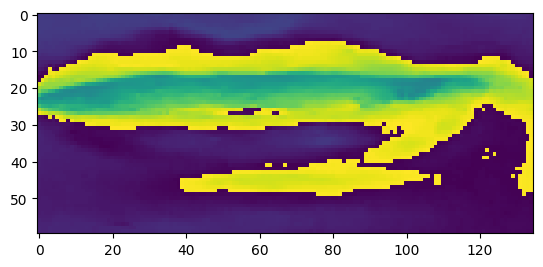

In [24]:
plt.imshow(frames[10])

In [25]:
alignments

<tf.Tensor: shape=(14,), dtype=int64, numpy=array([20,  1,  9, 32, 39, 13, 15, 21, 33, 39,  4, 15, 21, 30])>

In [26]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'tai3 mou4 dou1'>

In [27]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

2. Create Data Pipeline

In [28]:
from matplotlib import pyplot as plt

In [29]:
data = tf.data.Dataset.list_files('./data_cantonese/s1/*.mp4')
data = data.shuffle(510, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[20]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
# Determine the sizes for training and testing sets
total_samples = 255
train_size = int(0.8 * total_samples)

# Split the data
train_data = data.take(train_size)
test_data = data.skip(train_size)

In [30]:
# for sample in data:  # Adjust the number of samples to print
#     video_frames, label = sample
#     # print(video_frames.shape)
#     if(video_frames.shape[1] < 10):
#         file_path = sample[0].numpy().decode('utf-8')  # Decode the byte string to a regular string
#         # print("Video File Path:", file_path)
#         # print("No. of frames:", video_frames.shape[1])
#         print("Video Frames Shape:", video_frames.shape)
#         print("Label:", label.numpy())
#         print("~" * 50)

In [31]:
# # Assuming `data` is your dataset
# print("Element Spec:")
# print(data.element_spec)

# # Access the padded_shapes attribute for each element
# for element_spec in data.element_spec:
#     if isinstance(element_spec, tuple) and len(element_spec) == 2:
#         print("Padded Shape:", element_spec[1])


In [32]:
frames, alignments = data.as_numpy_iterator().next()

In [33]:
data.as_numpy_iterator().next()

(array([[[[[ 0.91797704],
           [ 0.9638759 ],
           [ 1.0556736 ],
           ...,
           [ 0.41308966],
           [ 0.55078626],
           [ 0.55078626]],
 
          [[ 0.5966851 ],
           [ 0.55078626],
           [ 0.64258397],
           ...,
           [ 0.3671908 ],
           [ 0.32129198],
           [ 0.55078626]],
 
          [[ 0.5966851 ],
           [ 0.55078626],
           [ 0.55078626],
           ...,
           [ 0.41308966],
           [ 0.5048874 ],
           [ 0.41308966]],
 
          ...,
 
          [[ 0.6884828 ],
           [ 0.6884828 ],
           [ 0.5966851 ],
           ...,
           [ 0.13769656],
           [ 0.13769656],
           [ 0.13769656]],
 
          [[ 0.7343816 ],
           [ 0.64258397],
           [ 0.5966851 ],
           ...,
           [ 0.0917977 ],
           [ 0.0917977 ],
           [ 0.0917977 ]],
 
          [[ 0.7343816 ],
           [ 0.7343816 ],
           [ 0.5966851 ],
           ...,
           [ 0

In [34]:
len(frames)

2

In [35]:
sample = data.as_numpy_iterator()

In [36]:
val = sample.next(); val[0]

array([[[[[0.14457004],
          [0.14457004],
          [0.07228502],
          ...,
          [1.3011303 ],
          [1.4818429 ],
          [1.5541278 ]],

         [[0.14457004],
          [0.10842752],
          [0.07228502],
          ...,
          [1.2288452 ],
          [1.3734154 ],
          [1.5179853 ]],

         [[0.14457004],
          [0.07228502],
          [0.03614251],
          ...,
          [1.3011303 ],
          [1.4457003 ],
          [1.5902704 ]],

         ...,

         [[0.65056515],
          [0.57828015],
          [0.6144226 ],
          ...,
          [1.1204177 ],
          [1.1204177 ],
          [1.0842752 ]],

         [[9.107912  ],
          [0.4337101 ],
          [0.6144226 ],
          ...,
          [1.1204177 ],
          [1.0842752 ],
          [1.0842752 ]],

         [[0.4698526 ],
          [0.5421376 ],
          [0.72285014],
          ...,
          [1.1204177 ],
          [1.0842752 ],
          [1.0842752 ]]],


        [[[0.1445

In [37]:
len(val[0])

2

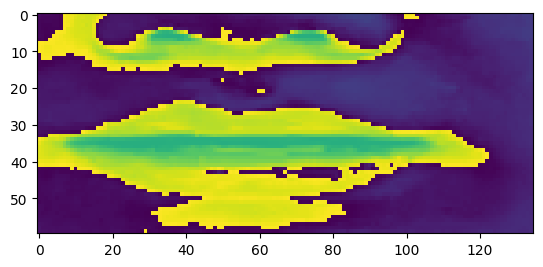

In [38]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][20])

In [39]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'mou5 sik6 gwo3'>

3.Design the Deep Neural Network

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

In [41]:
data.as_numpy_iterator().next()[0][0].shape

(75, 60, 135, 1)

In [42]:
def create_lip_reading_model(input_shape, num_classes):
    model = Sequential()
    
    # model.add(Masking(mask_value=0.0, input_shape=input_shape))
    model.add(Conv3D(128, 3, input_shape=input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1, 2, 2)))

    model.add(Conv3D(256, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1, 2, 2)))

    model.add(Conv3D(75, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1, 2, 2)))

    model.add(TimeDistributed(Flatten()))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, kernel_initializer='he_normal', activation='softmax'))

    return model


In [43]:
input_shape = (75,60,135,1)  # Modify based on actual input shape
num_classes =  char_to_num.vocabulary_size()+1 # Replace with the actual number of classes

In [44]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [45]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [46]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset
        self.dataset_iterator = None
        self.total_samples = None
        self.correct_word_predictions = 0
    
    def on_epoch_begin(self, epoch, logs=None) -> None:
        # Create a new iterator at the beginning of each epoch
        self.dataset_iterator = self.dataset.as_numpy_iterator()
        self.total_samples = 0  # Initialize total samples for the epoch
        self.correct_word_predictions = 0  # Initialize correct word predictions counter
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        # Calculate accuracy for the epoch based on words
        accuracy = self.correct_word_predictions / self.total_samples
        print(f'Epoch {epoch + 1} Word Accuracy: {accuracy * 100:.2f}%')

        # Reset counters for the next epoch
        self.total_samples = 0
        self.correct_word_predictions = 0

    def on_epoch_end(self, epoch, logs=None) -> None:
        # Iterate through batches and calculate word accuracy
        for batch_data in self.dataset.as_numpy_iterator():
            data = batch_data
            yhat = self.model.predict(data[0])
            decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()

            batch_size = len(decoded)
            self.total_samples += batch_size

            for x in range(batch_size):
                original_str = tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8')
                prediction_str = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')

                # Split strings into words
                original_words = original_str.split()
                prediction_words = prediction_str.split()

                # Check if each word in the prediction is correct
                for original_word, prediction_word in zip(original_words, prediction_words):
                    if original_word == prediction_word:
                        self.correct_word_predictions += 1

                print('Original:', original_str)
                print('Prediction:', prediction_str)
                print('~' * 100)


In [47]:
from tensorflow.keras.models import load_model
custom_objects = {'CTCLoss': CTCLoss}
checkpoint_directory = '/Users/dennislaw/documents/fyp_lip_reading_model/saved_models/tested_model_1'
# Ensure the checkpoint directory exists; if not, create it
os.makedirs(checkpoint_directory, exist_ok=True)
# Specify the checkpoint file path
checkpoint_path = os.path.join(checkpoint_directory, 'checkpoint')
# Check if there is a checkpoint file
if os.path.exists(checkpoint_path):
    print("Checkpoint exists in models.")
    # model = create_lip_reading_model(input_shape, num_classes)
    model = load_model(checkpoint_path,  custom_objects=custom_objects)
     # Retrieve the last epoch from the training history
    last_epoch = max(model.history.epoch) + 1 if hasattr(model.history, 'epoch') else 1
    # model.load_weights(checkpoint_path)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=CTCLoss)
else:
    # If there is no checkpoint, create a new model
    # input_shape = (100, 100, 720, 1)  # Modify based on your actual input shape
    # num_classes =  char_to_num.vocabulary_size()+1 # Replace with the actual number of classes
    model = create_lip_reading_model(input_shape, num_classes)
    print("No checkpoint found. Creating a new model.")


No checkpoint found. Creating a new model.


In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 60, 135, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 60, 135, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 30, 67, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 30, 67, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 30, 67, 256)   0         
                                                        

In [49]:
# for batch in train_data:
#     x, y_true = batch
#     y_pred = model.predict(x)
#     print("Label shape:", y_true.shape)
#     print("Prediction shape:", y_pred.shape)


In [50]:
yhat = model.predict(val[0])

1/1 [==============================] - 2s 2s/step


In [51]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'1111111111111111111111111111111111111111111111111111111111111111111111jjjjj'>

In [52]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'1111111111111111111111111111111111111111111111111111111111111111111111jjjjj'>

In [53]:
model.input_shape

(None, 75, 60, 135, 1)

In [54]:
model.output_shape

(None, 75, 41)

In [55]:
# from tensorflow.keras.utils import plot_model

# # Assuming 'model' is your neural network
# plot_model(model, to_file='model_network.png', show_shapes=True, show_layer_names=True)


4. Setup Training Options and Train

In [56]:
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss )

In [57]:
# print("Number of sequences in the batch:", batch_len.numpy())

In [58]:
checkpoint_callback = ModelCheckpoint(
    os.path.join('saved_models','tested_model_1'),
    monitor='loss', 
    save_weights_only=False, 
    mode='min',
    save_best_only=True,) 

In [59]:
schedule_callback = LearningRateScheduler(scheduler)

In [60]:
example_callback = ProduceExample(test_data)

In [61]:
callbacks = [checkpoint_callback, schedule_callback, example_callback]

In [62]:
tf.keras.utils.get_custom_objects()['CTCLoss'] = CTCLoss


In [ ]:
model.fit(train_data, validation_data=test_data, epochs=50, callbacks= callbacks)

Epoch 1/50
 44/204 [=====>........................] - ETA: 1:06:37 - loss: 75.2830

In [ ]:
loaded_model = tf.keras.models.load_model('model/tested_model4')

In [ ]:
test = test_data.as_numpy_iterator()

In [ ]:
sample = test.next()

In [ ]:
yhat = loaded_model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTION')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [ ]:
model.save("model_4.h5")

In [ ]:
load_saved_model = tf.keras.models.load_model("model_4.h5")
load_saved_model.summary()

In [ ]:
import pandas as pd
metrics_df = pd.DataFrame(load_saved_model.history)

In [ ]:
metrics_df